In [ ]:
#Import all necessary libraries

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as Model

try:
    from torchmetrics import Accuracy
except:
    !pip install torchmetrics
    from torchmetrics import Accuracy

import os
import shutil
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
from tqdm import tqdm
import csv
from PIL import Image
from torch.utils.data import Dataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sb
import textwrap
import warnings
warnings.filterwarnings("ignore")

try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 56.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 43.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 65.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━

In [ ]:
#Select GPU as device if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Selected device:", device)

if device.type =='cuda':
  print(torch.cuda.get_device_name(device))

Selected device: cuda
Tesla V100-SXM2-16GB


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile

folder_path = '/content/drive/MyDrive/DAR_Deep Learning Model/SAM-DD'
file_dir = '/content/SAM-DD/'
os.makedirs(file_dir, exist_ok = True)
target_folder = 'front'

#Upload train data folder to google colab files directory
if not os.path.exists(os.path.join (file_dir, target_folder)):
  zip_train= zipfile.ZipFile(os.path.join(folder_path, 'SAM-DD(train).zip'), 'r') #Open train zip file in read mode
  zip_train.extractall(file_dir) #Store file to google colab
  zip_train.close()

In [ ]:
class_dict = {0 : "safe driving",
              1 : "drinking",
              2 : "talking on the phone - left",
              3 : "talking on the phone - right",
              4 : "texting - left",
              5 : "texting - right",
              6 : "Doing hair",
              7 : "Adjusting specs",
              8 : "Reaching behind",
              9 : "Sleeping"}

In [ ]:
path_train = "/content/SAM-DD/SAM-DD(train)/Tester/front_RGB"
classes = [c for c in os.listdir(path_train) if not c.startswith(".")]
classes.sort()
num_classes = len(classes)
print(classes)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


Total number of  data : 36839


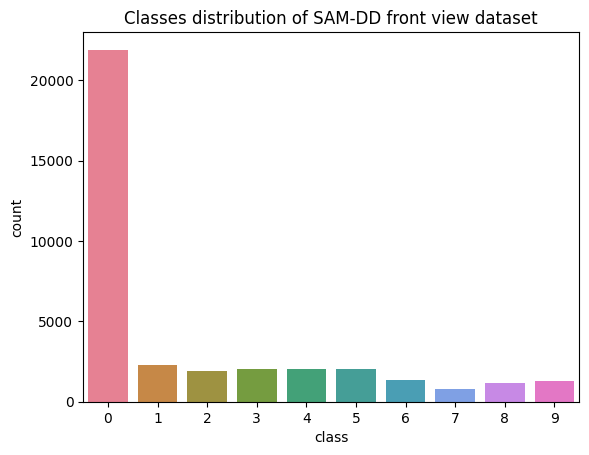

In [ ]:
d = {"img" : [], "class" : []}
for c in classes:
    imgs = [img for img in os.listdir(os.path.join(path_train,c)) if not img.startswith(".")]
    for img in imgs:
        d["img"].append(img)
        d["class"].append(c)
df = pd.DataFrame(d)
sb.set_palette("Set2")
ax = sb.countplot(data=df, x="class", hue="class")
ax.set(title="Classes distribution of SAM-DD front view dataset")
print("Total number of  data :",len(df))

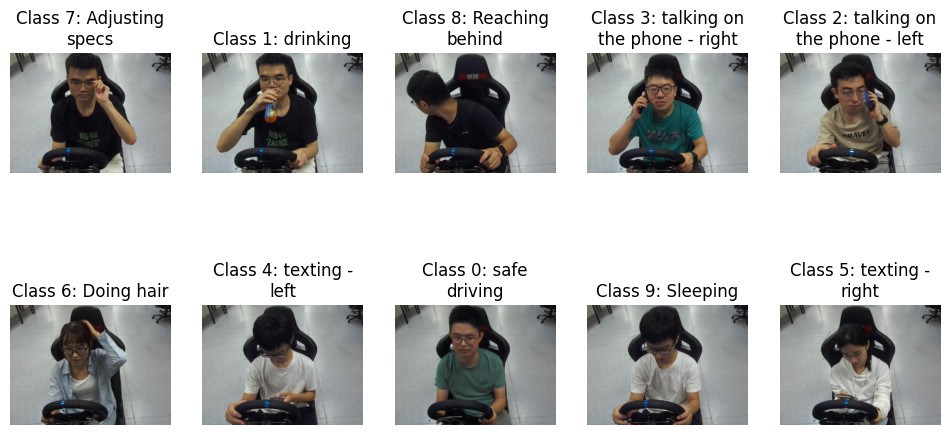

In [ ]:
torch.manual_seed(42)
fig, axs = plt.subplots(2, 5, figsize=(12, 6))

for i, class_name in enumerate(os.listdir(path_train)):
  class_idx = classes.index(class_name)
  class_path = os.path.join(path_train, class_name)
  images = [img for img in os.listdir(class_path)]
  random_index = np.random.randint(len(images))
  image_path = os.path.join(class_path, images[random_index])
  image = mpimg.imread(image_path)


  row = i // 5  # Determine the row in the grid
  col = i % 5   # Determine the column in the grid
  ax = axs[row, col]  # Select the current subplot
  ax.imshow(image)
  ax.axis('off')
 # Wrap the title text
  title_text = f'Class {class_name}: {class_dict[class_idx]}'
  wrapped_text = textwrap.fill(title_text, width=20)  # Adjust 'width' as needed
  ax.set_title(wrapped_text, fontdict={'fontsize': 12, 'fontweight': 'medium'})

In [ ]:
torch.manual_seed(42)
data = datasets.ImageFolder(root = path_train)

valid_size = int(0.2*len(data))
test_size = int(0.1*len(data))
train_size = len(data)-valid_size-test_size

train_data, valid_data, test_data = random_split(data, [train_size, valid_size, test_size])

In [ ]:
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]
image_size = (224,224)

color_jitter = transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
rotation = transforms.RandomRotation(15)
gaussian_blur = transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))

train_transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.RandomApply([color_jitter], p=0.3),
        transforms.RandomApply([rotation], p=0.5),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomApply([gaussian_blur], p=0.3),
        transforms.ToTensor(),
        transforms.Normalize(norm_mean, norm_std)

    ])

valid_transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(norm_mean, norm_std)
    ])
test_transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(norm_mean, norm_std)
    ])

In [ ]:
class TransformDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [ ]:
train_data = TransformDataset(train_data, transform=train_transform)
valid_data = TransformDataset(valid_data, transform=valid_transform)
test_data = TransformDataset(test_data, transform=test_transform)

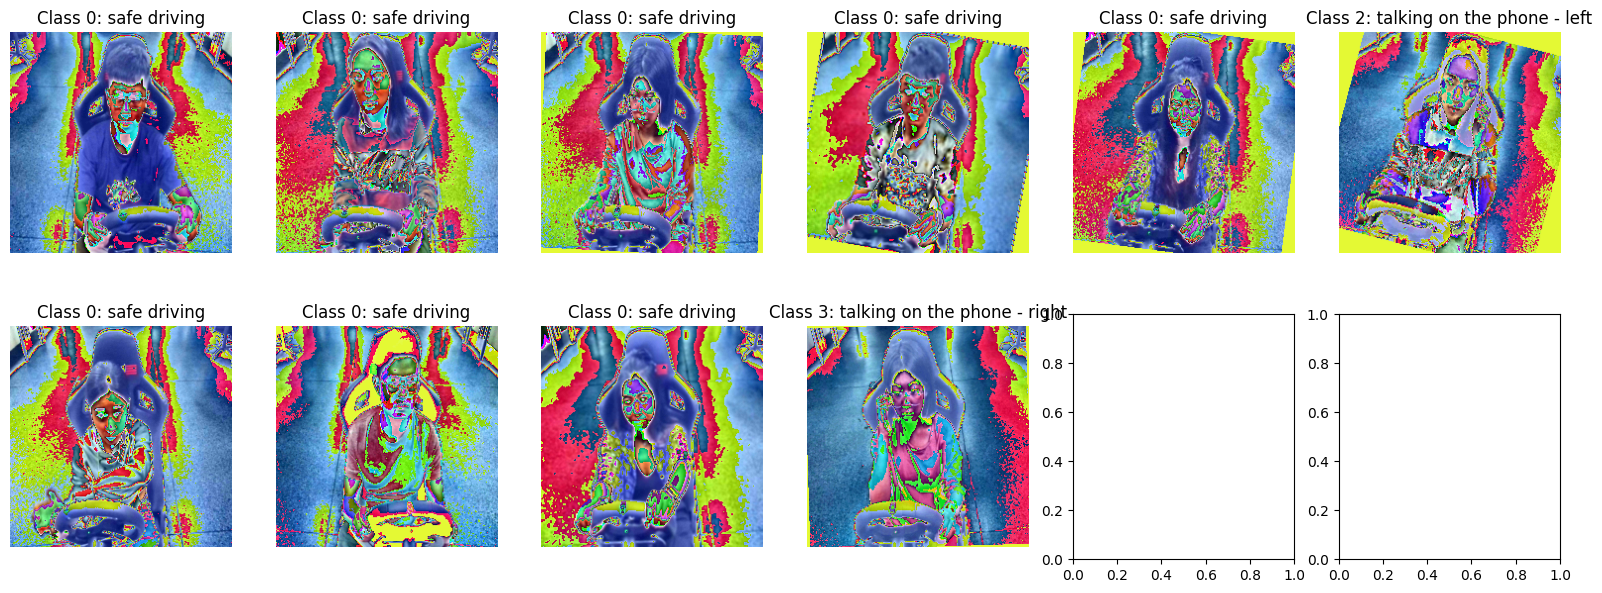

In [ ]:
total_train_data = len(train_data)

fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(20, 7))  # Adjust as needed for layout
axes = axes.flatten()

for i in range (10):
  idx = np.random.randint(total_train_data)
  image, label = train_data[idx]
  # Convert the tensor image back to a PIL Image for displaying
  image_pil = transforms.ToPILImage()(image)

  axes[i].imshow(image_pil)
  axes[i].axis('off')  # Don't show axes for clarity
  axes[i].set_title(f"Class {label}: {class_dict[label]}")  # Optional: Display the label

In [ ]:
batch_size = 16

#Create a data loader with batches
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
print(f"Number of images in the train dataset: {len(train_loader.dataset)}")
print(f"Number of images in the valid dataset: {len(valid_loader.dataset)}")
print(f"Number of images in the test dataset: {len(test_loader.dataset)}")

Number of images in the train dataset: 25789
Number of images in the valid dataset: 7367
Number of images in the test dataset: 3683


In [ ]:
train_features_batch, train_labels_batch = next(iter(train_loader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([16, 3, 224, 224]), torch.Size([16]))

In [ ]:
model = None

if model == None:
  model = Model.mobilenet_v3_large(weights ='DEFAULT', pretrained = True)

num_features = model.classifier[0].in_features
output_class = 10

model.classifier = nn.Sequential(
    nn.Linear(in_features = num_features, out_features = 1280),
    nn.Hardswish(),
    nn.Dropout(0.5),
    nn.Linear(1280, output_class))

pretrained_features = model.features.to(device)

for param in model.features.parameters():
    param.requires_grad = False

model.to(device)


Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-5c1a4163.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-5c1a4163.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 144MB/s]


MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [ ]:
summary(model=model,
        input_size=(16, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
MobileNetV3 (MobileNetV3)                                    [16, 3, 224, 224]    [16, 10]             --                   Partial
├─Sequential (features)                                      [16, 3, 224, 224]    [16, 960, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [16, 3, 224, 224]    [16, 16, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [16, 3, 224, 224]    [16, 16, 112, 112]   (432)                False
│    │    └─BatchNorm2d (1)                                  [16, 16, 112, 112]   [16, 16, 112, 112]   (32)                 False
│    │    └─Hardswish (2)                                    [16, 16, 112, 112]   [16, 16, 112, 112]   --                   --
│    └─InvertedResidual (1)                                  [16, 16, 112, 112]   [16, 

In [ ]:
criterion= nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
lrscheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=2, threshold=0.01, threshold_mode='rel')

In [ ]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

In [ ]:
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_accuracy):
        if self.best_score is None:
            self.best_score = val_accuracy
        elif val_accuracy < self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_accuracy
            self.counter = 0

In [ ]:
early_stopping = EarlyStopping(patience=4, min_delta=0.005)

In [ ]:
class CSVLogger:
    def __init__(self, filename, fieldnames=['epoch','learning_rate', 'epoch_duration', 'train_loss', 'train_acc', 'valid_loss', 'valid_acc']):
        self.filename = filename
        self.fieldnames = fieldnames

        # Create file and write header
        with open(self.filename, 'w', newline='') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=self.fieldnames)
            writer.writeheader()

    def log(self, epoch, lr, epoch_duration, train_loss, train_acc, valid_loss, valid_acc):
        with open(self.filename, 'a', newline='') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=self.fieldnames)
            writer.writerow({
                'epoch': epoch,
                'learning_rate': lr,
                'epoch_duration': epoch_duration,
                'train_loss': train_loss,
                'train_acc': train_acc,
                'valid_loss': valid_loss,
                'valid_acc': valid_acc
            })

In [ ]:
log_path = os.path.join(folder_path,'training_log/mobilenetv3l_front(gradual)')
if not os.path.exists(log_path):
    os.makedirs(log_path)

In [ ]:
logger = CSVLogger(os.path.join(log_path,'training_log.csv'))

In [ ]:
cp_filename = os.path.join(log_path,'my_checkpoint.pth.tar')

def save_checkpoint(state, filename=cp_filename):
    print("=> Saving checkpoint")
    torch.save(state, filename)

In [ ]:
def unfreeze_layer(optimizer, model, current_unfreeze_index):
    layer_groups = list(reversed(list(model.children())))
    next_unfreeze_index = current_unfreeze_index + 2

    existing_params = set(param for group in optimizer.param_groups for param in group['params'])
    new_params = []

    for i in range(current_unfreeze_index, min(next_unfreeze_index, len(layer_groups))):
        for param in layer_groups[i].parameters():
            if param not in existing_params:
                param.requires_grad = True
                new_params.append(param)

    if new_params:
        optimizer.add_param_group({'params': new_params})

    return next_unfreeze_index

In [ ]:
def train_model(model, criterion, optimizer, scheduler, epochs = 5):
    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []
    best_acc = 0
    current_unfreeze_layer = 0
    # Start the timer
    start_time = time.time()
    for epoch in tqdm(range(epochs)):
      since = time.time()
      print(f"\nEpoch: {epoch}\n-------")
      #------- Training----------
      train_loss, train_acc = 0, 0
      current_unfreeze_layer = unfreeze_layer(optimizer, model, current_unfreeze_layer)

      model.train()
      for batch, (X_train, y_train) in enumerate(train_loader):
        model.train()
        # 1. Forward pass
        X_train = X_train.to(device)
        y_train = y_train.to(device)
        optimizer.zero_grad()  # Reset gradients at the start of each epoch


        train_pred = model(X_train)
        loss = criterion(train_pred, y_train)
        train_loss +=loss

        # 4. Calculate accuracy (preds need to be same as y_true)
        train_acc += accuracy_fn(y_true=y_train, y_pred=train_pred.argmax(dim=1))
        # 5. Loss backward
        loss.backward()

        # 6. Optimizer step
        optimizer.step()

        # Print out how many samples have been seen
        if batch % 100 == 0:
          print(f"Looked at {batch * len(X_train)}/{len(train_loader.dataset)} samples")

      # Divide total train loss by length of train dataloader (average loss per batch per epoch)
      train_loss /= len(train_loader)

      # Divide total accuracy by length of test dataloader (per batch)
      train_acc /= len(train_loader)

      epoch_duration = time.time()-since
      train_losses.append(train_loss)
      train_accuracies.append(train_acc)

      ### Testing
      # Setup variables for accumulatively adding up loss and accuracy
      valid_loss = 0
      valid_acc = 0
      model.eval()
      with torch.inference_mode():
        for X_valid, y_valid in valid_loader:
          # 1. Forward pass
          X_valid = X_valid.to(device)
          y_valid = y_valid.to(device)
          valid_pred = model(X_valid)

          valid_loss += criterion(valid_pred, y_valid)

          # 3. Calculate accuracy (preds need to be same as y_true)
          valid_acc += accuracy_fn(y_true=y_valid, y_pred=valid_pred.argmax(dim=1))

        # Calculations on test metrics need to happen inside torch.inference_mode()

        # Divide total accuracy by length of test dataloader (per batch)
        valid_loss /= len(valid_loader)
        valid_acc /= len(valid_loader)
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_acc)

      # Model Checkpointing
      if valid_acc > best_acc:
        best_acc = valid_acc
        save_checkpoint({'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()})

      for param_group in optimizer.param_groups:
        lr = param_group['lr']
        print(lr)

      scheduler.step(valid_acc)

      ## Print out what's happening
      print(f"\nEpoch duration: {epoch_duration:.0f}s, lr: {lr}, Train loss: {train_loss:.5f}, Train acc: {train_acc:.2f}% | Valid loss: {valid_loss:.2f}, Valid acc: {valid_acc:.2f}%\n")

      logger.log(epoch, lr, epoch_duration, train_loss, train_acc, valid_loss, valid_acc)


      early_stopping(valid_acc)
      if early_stopping.early_stop:
        print("Early stopping triggered")
        break

    print("Finished Training")
    total_training_time = time.time() - start_time
    print(f"Total training time: {total_training_time:.2f}")
    return model, train_losses, train_accuracies,valid_losses, valid_accuracies



In [ ]:
model, train_losses, training_accs, valid_losses, valid_accs = train_model(model, criterion, optimizer, lrscheduler, epochs=50)

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 0
-------
Looked at 0/25789 samples
Looked at 1600/25789 samples
Looked at 3200/25789 samples
Looked at 4800/25789 samples
Looked at 6400/25789 samples
Looked at 8000/25789 samples
Looked at 9600/25789 samples
Looked at 11200/25789 samples
Looked at 12800/25789 samples
Looked at 14400/25789 samples
Looked at 16000/25789 samples
Looked at 17600/25789 samples
Looked at 19200/25789 samples
Looked at 20800/25789 samples
Looked at 22400/25789 samples
Looked at 24000/25789 samples
Looked at 25600/25789 samples
=> Saving checkpoint
0.001

Epoch duration: 262s, lr: 0.001, Train loss: 1.34741, Train acc: 60.84% | Valid loss: 1.06, Valid acc: 68.61%



  2%|▏         | 1/50 [05:20<4:22:06, 320.95s/it]


Epoch: 1
-------
Looked at 0/25789 samples
Looked at 1600/25789 samples
Looked at 3200/25789 samples
Looked at 4800/25789 samples
Looked at 6400/25789 samples
Looked at 8000/25789 samples
Looked at 9600/25789 samples
Looked at 11200/25789 samples
Looked at 12800/25789 samples
Looked at 14400/25789 samples
Looked at 16000/25789 samples
Looked at 17600/25789 samples
Looked at 19200/25789 samples
Looked at 20800/25789 samples
Looked at 22400/25789 samples
Looked at 24000/25789 samples
Looked at 25600/25789 samples


  4%|▍         | 2/50 [09:59<3:56:46, 295.98s/it]

=> Saving checkpoint
0.001

Epoch duration: 226s, lr: 0.001, Train loss: 1.04013, Train acc: 69.94% | Valid loss: 0.79, Valid acc: 77.67%


Epoch: 2
-------
Looked at 0/25789 samples
Looked at 1600/25789 samples
Looked at 3200/25789 samples
Looked at 4800/25789 samples
Looked at 6400/25789 samples
Looked at 8000/25789 samples
Looked at 9600/25789 samples
Looked at 11200/25789 samples
Looked at 12800/25789 samples
Looked at 14400/25789 samples
Looked at 16000/25789 samples
Looked at 17600/25789 samples
Looked at 19200/25789 samples
Looked at 20800/25789 samples
Looked at 22400/25789 samples
Looked at 24000/25789 samples
Looked at 25600/25789 samples


  6%|▌         | 3/50 [14:43<3:47:40, 290.66s/it]

=> Saving checkpoint
0.001

Epoch duration: 229s, lr: 0.001, Train loss: 0.85116, Train acc: 75.48% | Valid loss: 0.60, Valid acc: 83.63%


Epoch: 3
-------
Looked at 0/25789 samples
Looked at 1600/25789 samples
Looked at 3200/25789 samples
Looked at 4800/25789 samples
Looked at 6400/25789 samples
Looked at 8000/25789 samples
Looked at 9600/25789 samples
Looked at 11200/25789 samples
Looked at 12800/25789 samples
Looked at 14400/25789 samples
Looked at 16000/25789 samples
Looked at 17600/25789 samples
Looked at 19200/25789 samples
Looked at 20800/25789 samples
Looked at 22400/25789 samples
Looked at 24000/25789 samples
Looked at 25600/25789 samples


  8%|▊         | 4/50 [19:35<3:43:06, 291.01s/it]

=> Saving checkpoint
0.001

Epoch duration: 234s, lr: 0.001, Train loss: 0.72823, Train acc: 78.80% | Valid loss: 0.50, Valid acc: 85.05%


Epoch: 4
-------
Looked at 0/25789 samples
Looked at 1600/25789 samples
Looked at 3200/25789 samples
Looked at 4800/25789 samples
Looked at 6400/25789 samples
Looked at 8000/25789 samples
Looked at 9600/25789 samples
Looked at 11200/25789 samples
Looked at 12800/25789 samples
Looked at 14400/25789 samples
Looked at 16000/25789 samples
Looked at 17600/25789 samples
Looked at 19200/25789 samples
Looked at 20800/25789 samples
Looked at 22400/25789 samples
Looked at 24000/25789 samples
Looked at 25600/25789 samples


 10%|█         | 5/50 [24:29<3:38:58, 291.98s/it]

=> Saving checkpoint
0.001

Epoch duration: 239s, lr: 0.001, Train loss: 0.64488, Train acc: 80.89% | Valid loss: 0.42, Valid acc: 88.48%


Epoch: 5
-------
Looked at 0/25789 samples
Looked at 1600/25789 samples
Looked at 3200/25789 samples
Looked at 4800/25789 samples
Looked at 6400/25789 samples
Looked at 8000/25789 samples
Looked at 9600/25789 samples
Looked at 11200/25789 samples
Looked at 12800/25789 samples
Looked at 14400/25789 samples
Looked at 16000/25789 samples
Looked at 17600/25789 samples
Looked at 19200/25789 samples
Looked at 20800/25789 samples
Looked at 22400/25789 samples
Looked at 24000/25789 samples
Looked at 25600/25789 samples


 12%|█▏        | 6/50 [29:19<3:33:46, 291.51s/it]

=> Saving checkpoint
0.001

Epoch duration: 237s, lr: 0.001, Train loss: 0.57842, Train acc: 82.71% | Valid loss: 0.36, Valid acc: 89.02%


Epoch: 6
-------
Looked at 0/25789 samples
Looked at 1600/25789 samples
Looked at 3200/25789 samples
Looked at 4800/25789 samples
Looked at 6400/25789 samples
Looked at 8000/25789 samples
Looked at 9600/25789 samples
Looked at 11200/25789 samples
Looked at 12800/25789 samples
Looked at 14400/25789 samples
Looked at 16000/25789 samples
Looked at 17600/25789 samples
Looked at 19200/25789 samples
Looked at 20800/25789 samples
Looked at 22400/25789 samples
Looked at 24000/25789 samples
Looked at 25600/25789 samples


 14%|█▍        | 7/50 [34:21<3:31:23, 294.97s/it]

=> Saving checkpoint
0.001

Epoch duration: 244s, lr: 0.001, Train loss: 0.54051, Train acc: 84.06% | Valid loss: 0.33, Valid acc: 89.97%


Epoch: 7
-------
Looked at 0/25789 samples
Looked at 1600/25789 samples
Looked at 3200/25789 samples
Looked at 4800/25789 samples
Looked at 6400/25789 samples
Looked at 8000/25789 samples
Looked at 9600/25789 samples
Looked at 11200/25789 samples
Looked at 12800/25789 samples
Looked at 14400/25789 samples
Looked at 16000/25789 samples
Looked at 17600/25789 samples
Looked at 19200/25789 samples
Looked at 20800/25789 samples
Looked at 22400/25789 samples
Looked at 24000/25789 samples
Looked at 25600/25789 samples


 16%|█▌        | 8/50 [39:25<3:28:22, 297.69s/it]

=> Saving checkpoint
0.001

Epoch duration: 247s, lr: 0.001, Train loss: 0.50370, Train acc: 84.57% | Valid loss: 0.29, Valid acc: 92.06%


Epoch: 8
-------
Looked at 0/25789 samples
Looked at 1600/25789 samples
Looked at 3200/25789 samples
Looked at 4800/25789 samples
Looked at 6400/25789 samples
Looked at 8000/25789 samples
Looked at 9600/25789 samples
Looked at 11200/25789 samples
Looked at 12800/25789 samples
Looked at 14400/25789 samples
Looked at 16000/25789 samples
Looked at 17600/25789 samples
Looked at 19200/25789 samples
Looked at 20800/25789 samples
Looked at 22400/25789 samples
Looked at 24000/25789 samples
Looked at 25600/25789 samples


 18%|█▊        | 9/50 [44:06<3:19:54, 292.54s/it]

0.001

Epoch duration: 228s, lr: 0.001, Train loss: 0.46846, Train acc: 86.08% | Valid loss: 0.27, Valid acc: 91.93%


Epoch: 9
-------
Looked at 0/25789 samples
Looked at 1600/25789 samples
Looked at 3200/25789 samples
Looked at 4800/25789 samples
Looked at 6400/25789 samples
Looked at 8000/25789 samples
Looked at 9600/25789 samples
Looked at 11200/25789 samples
Looked at 12800/25789 samples
Looked at 14400/25789 samples
Looked at 16000/25789 samples
Looked at 17600/25789 samples
Looked at 19200/25789 samples
Looked at 20800/25789 samples
Looked at 22400/25789 samples
Looked at 24000/25789 samples
Looked at 25600/25789 samples


 20%|██        | 10/50 [48:42<3:11:33, 287.34s/it]

=> Saving checkpoint
0.001

Epoch duration: 222s, lr: 0.001, Train loss: 0.45685, Train acc: 86.20% | Valid loss: 0.25, Valid acc: 92.49%


Epoch: 10
-------
Looked at 0/25789 samples
Looked at 1600/25789 samples
Looked at 3200/25789 samples
Looked at 4800/25789 samples
Looked at 6400/25789 samples
Looked at 8000/25789 samples
Looked at 9600/25789 samples
Looked at 11200/25789 samples
Looked at 12800/25789 samples
Looked at 14400/25789 samples
Looked at 16000/25789 samples
Looked at 17600/25789 samples
Looked at 19200/25789 samples
Looked at 20800/25789 samples
Looked at 22400/25789 samples
Looked at 24000/25789 samples
Looked at 25600/25789 samples


 22%|██▏       | 11/50 [53:17<3:04:25, 283.74s/it]

=> Saving checkpoint
0.001

Epoch duration: 224s, lr: 0.001, Train loss: 0.43379, Train acc: 86.87% | Valid loss: 0.23, Valid acc: 93.28%


Epoch: 11
-------
Looked at 0/25789 samples
Looked at 1600/25789 samples
Looked at 3200/25789 samples
Looked at 4800/25789 samples
Looked at 6400/25789 samples
Looked at 8000/25789 samples
Looked at 9600/25789 samples
Looked at 11200/25789 samples
Looked at 12800/25789 samples
Looked at 14400/25789 samples
Looked at 16000/25789 samples
Looked at 17600/25789 samples
Looked at 19200/25789 samples
Looked at 20800/25789 samples
Looked at 22400/25789 samples
Looked at 24000/25789 samples
Looked at 25600/25789 samples


 24%|██▍       | 12/50 [57:52<2:57:58, 281.02s/it]

=> Saving checkpoint
0.001

Epoch duration: 223s, lr: 0.001, Train loss: 0.41782, Train acc: 87.21% | Valid loss: 0.22, Valid acc: 93.29%


Epoch: 12
-------
Looked at 0/25789 samples
Looked at 1600/25789 samples
Looked at 3200/25789 samples
Looked at 4800/25789 samples
Looked at 6400/25789 samples
Looked at 8000/25789 samples
Looked at 9600/25789 samples
Looked at 11200/25789 samples
Looked at 12800/25789 samples
Looked at 14400/25789 samples
Looked at 16000/25789 samples
Looked at 17600/25789 samples
Looked at 19200/25789 samples
Looked at 20800/25789 samples
Looked at 22400/25789 samples
Looked at 24000/25789 samples
Looked at 25600/25789 samples


 26%|██▌       | 13/50 [1:02:31<2:52:52, 280.34s/it]

=> Saving checkpoint
0.001

Epoch duration: 226s, lr: 0.001, Train loss: 0.40453, Train acc: 87.55% | Valid loss: 0.21, Valid acc: 93.56%


Epoch: 13
-------
Looked at 0/25789 samples
Looked at 1600/25789 samples
Looked at 3200/25789 samples
Looked at 4800/25789 samples
Looked at 6400/25789 samples
Looked at 8000/25789 samples
Looked at 9600/25789 samples
Looked at 11200/25789 samples
Looked at 12800/25789 samples
Looked at 14400/25789 samples
Looked at 16000/25789 samples
Looked at 17600/25789 samples
Looked at 19200/25789 samples
Looked at 20800/25789 samples
Looked at 22400/25789 samples
Looked at 24000/25789 samples
Looked at 25600/25789 samples


 28%|██▊       | 14/50 [1:07:12<2:48:23, 280.66s/it]

=> Saving checkpoint
0.001

Epoch duration: 229s, lr: 0.001, Train loss: 0.39073, Train acc: 88.15% | Valid loss: 0.20, Valid acc: 94.06%


Epoch: 14
-------
Looked at 0/25789 samples
Looked at 1600/25789 samples
Looked at 3200/25789 samples
Looked at 4800/25789 samples
Looked at 6400/25789 samples
Looked at 8000/25789 samples
Looked at 9600/25789 samples
Looked at 11200/25789 samples
Looked at 12800/25789 samples
Looked at 14400/25789 samples
Looked at 16000/25789 samples
Looked at 17600/25789 samples
Looked at 19200/25789 samples
Looked at 20800/25789 samples
Looked at 22400/25789 samples
Looked at 24000/25789 samples
Looked at 25600/25789 samples


 30%|███       | 15/50 [1:11:51<2:43:22, 280.07s/it]

0.0001

Epoch duration: 226s, lr: 0.0001, Train loss: 0.37830, Train acc: 88.35% | Valid loss: 0.20, Valid acc: 93.91%


Epoch: 15
-------
Looked at 0/25789 samples
Looked at 1600/25789 samples
Looked at 3200/25789 samples
Looked at 4800/25789 samples
Looked at 6400/25789 samples
Looked at 8000/25789 samples
Looked at 9600/25789 samples
Looked at 11200/25789 samples
Looked at 12800/25789 samples
Looked at 14400/25789 samples
Looked at 16000/25789 samples
Looked at 17600/25789 samples
Looked at 19200/25789 samples
Looked at 20800/25789 samples
Looked at 22400/25789 samples
Looked at 24000/25789 samples
Looked at 25600/25789 samples


 32%|███▏      | 16/50 [1:16:29<2:38:26, 279.61s/it]

0.0001

Epoch duration: 227s, lr: 0.0001, Train loss: 0.37481, Train acc: 88.62% | Valid loss: 0.20, Valid acc: 93.84%


Epoch: 16
-------
Looked at 0/25789 samples
Looked at 1600/25789 samples
Looked at 3200/25789 samples
Looked at 4800/25789 samples
Looked at 6400/25789 samples
Looked at 8000/25789 samples
Looked at 9600/25789 samples
Looked at 11200/25789 samples
Looked at 12800/25789 samples
Looked at 14400/25789 samples
Looked at 16000/25789 samples
Looked at 17600/25789 samples
Looked at 19200/25789 samples
Looked at 20800/25789 samples
Looked at 22400/25789 samples
Looked at 24000/25789 samples
Looked at 25600/25789 samples


 34%|███▍      | 17/50 [1:21:09<2:33:48, 279.65s/it]

=> Saving checkpoint
0.0001

Epoch duration: 227s, lr: 0.0001, Train loss: 0.38097, Train acc: 88.22% | Valid loss: 0.20, Valid acc: 94.10%


Epoch: 17
-------
Looked at 0/25789 samples
Looked at 1600/25789 samples
Looked at 3200/25789 samples
Looked at 4800/25789 samples
Looked at 6400/25789 samples
Looked at 8000/25789 samples
Looked at 9600/25789 samples
Looked at 11200/25789 samples
Looked at 12800/25789 samples
Looked at 14400/25789 samples
Looked at 16000/25789 samples
Looked at 17600/25789 samples
Looked at 19200/25789 samples
Looked at 20800/25789 samples
Looked at 22400/25789 samples
Looked at 24000/25789 samples
Looked at 25600/25789 samples


 36%|███▌      | 18/50 [1:25:51<2:29:26, 280.21s/it]

1e-05

Epoch duration: 227s, lr: 1e-05, Train loss: 0.37060, Train acc: 88.61% | Valid loss: 0.19, Valid acc: 94.10%


Epoch: 18
-------
Looked at 0/25789 samples
Looked at 1600/25789 samples
Looked at 3200/25789 samples
Looked at 4800/25789 samples
Looked at 6400/25789 samples
Looked at 8000/25789 samples
Looked at 9600/25789 samples
Looked at 11200/25789 samples
Looked at 12800/25789 samples
Looked at 14400/25789 samples
Looked at 16000/25789 samples
Looked at 17600/25789 samples
Looked at 19200/25789 samples
Looked at 20800/25789 samples
Looked at 22400/25789 samples
Looked at 24000/25789 samples
Looked at 25600/25789 samples


 38%|███▊      | 19/50 [1:30:42<2:26:29, 283.54s/it]

1e-05

Epoch duration: 235s, lr: 1e-05, Train loss: 0.37183, Train acc: 88.62% | Valid loss: 0.20, Valid acc: 93.98%


Epoch: 19
-------
Looked at 0/25789 samples
Looked at 1600/25789 samples
Looked at 3200/25789 samples
Looked at 4800/25789 samples
Looked at 6400/25789 samples
Looked at 8000/25789 samples
Looked at 9600/25789 samples
Looked at 11200/25789 samples
Looked at 12800/25789 samples
Looked at 14400/25789 samples
Looked at 16000/25789 samples
Looked at 17600/25789 samples
Looked at 19200/25789 samples
Looked at 20800/25789 samples
Looked at 22400/25789 samples
Looked at 24000/25789 samples
Looked at 25600/25789 samples


 40%|████      | 20/50 [1:35:34<2:23:06, 286.21s/it]

1e-05

Epoch duration: 237s, lr: 1e-05, Train loss: 0.37549, Train acc: 88.60% | Valid loss: 0.20, Valid acc: 94.08%


Epoch: 20
-------
Looked at 0/25789 samples
Looked at 1600/25789 samples
Looked at 3200/25789 samples
Looked at 4800/25789 samples
Looked at 6400/25789 samples
Looked at 8000/25789 samples
Looked at 9600/25789 samples
Looked at 11200/25789 samples
Looked at 12800/25789 samples
Looked at 14400/25789 samples
Looked at 16000/25789 samples
Looked at 17600/25789 samples
Looked at 19200/25789 samples
Looked at 20800/25789 samples
Looked at 22400/25789 samples
Looked at 24000/25789 samples
Looked at 25600/25789 samples


 40%|████      | 20/50 [1:40:26<2:30:39, 301.30s/it]

1.0000000000000002e-06

Epoch duration: 236s, lr: 1.0000000000000002e-06, Train loss: 0.36993, Train acc: 88.70% | Valid loss: 0.20, Valid acc: 94.05%

Early stopping triggered
Finished Training
Total training time: 6026.10


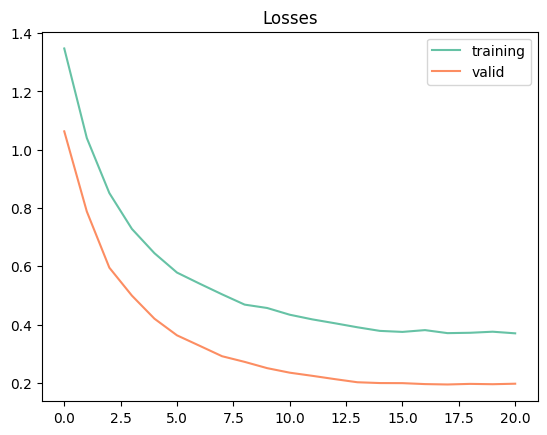

In [ ]:
training_losses_cpu = [loss.detach().cpu().numpy() for loss in train_losses]
valid_losses_cpu = [loss.detach().cpu().numpy() for loss in valid_losses]

plt.title('Losses')
plt.plot(training_losses_cpu, label='training')
plt.plot(valid_losses_cpu, label='valid')
plt.legend()
plt.show()


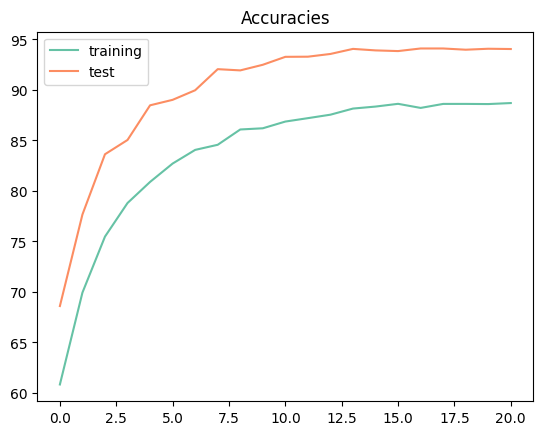

In [ ]:
plt.title('Accuracies')
plt.plot(training_accs, label = 'training')
plt.plot(valid_accs, label = 'test')
plt.legend()
plt.show()

In [ ]:
model = None

if model == None:
  model = Model.mobilenet_v3_large()

num_feature = model.classifier[0].in_features
output_shape = num_classes

model.classifier = nn.Sequential(
    nn.Linear(in_features = num_feature, out_features = 1280),
    nn.Hardswish(),
    nn.Dropout(0.5),
    nn.Linear(1280, output_shape)
)



In [ ]:
checkpoint_path = os.path.join(log_path, 'my_checkpoint.pth.tar')

if torch.cuda.is_available():
    checkpoint = torch.load(checkpoint_path)
else:
    # For loading on CPU when trained on GPU
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))

# Load the model state
model.load_state_dict(checkpoint['state_dict'])

# Move the model to the device
model.to(device)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [ ]:
summary(model=model,
        input_size=(batch_size, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
MobileNetV3 (MobileNetV3)                                    [16, 3, 224, 224]    [16, 10]             --                   True
├─Sequential (features)                                      [16, 3, 224, 224]    [16, 960, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [16, 3, 224, 224]    [16, 16, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [16, 3, 224, 224]    [16, 16, 112, 112]   432                  True
│    │    └─BatchNorm2d (1)                                  [16, 16, 112, 112]   [16, 16, 112, 112]   32                   True
│    │    └─Hardswish (2)                                    [16, 16, 112, 112]   [16, 16, 112, 112]   --                   --
│    └─InvertedResidual (1)                                  [16, 16, 112, 112]   [16, 16, 112

In [ ]:
total_images = len(test_loader.dataset)
print(f"Total number of images in the test dataset: {total_images}")

Total number of images in the test dataset: 3683


In [ ]:
# Parameters for visualization
num_images_to_display = 20
images_per_row = 5
num_rows = 4
images_displayed = 0

# Prepare the figure for visualization
fig, axes = plt.subplots(num_rows, images_per_row, figsize=(15, 12))
axes = axes.flatten()

# Start the timer
start_time = time.time()

# Prediction phase
all_preds = []
all_true_labels = []
images_to_display = []

model.eval()
with torch.no_grad():
    for X_test, y_test in test_loader:
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        test_pred = model(X_test)
        preds = test_pred.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_true_labels.extend(y_test.cpu().numpy())


        # Store images for visualization
        if len(images_to_display) < num_images_to_display:
            images_to_display.extend(X_test.cpu().numpy())

# Convert lists to numpy arrays for metric calculation
all_preds_np = np.array(all_preds)
all_true_labels_np = np.array(all_true_labels)

# Calculate metrics
precision = precision_score(all_true_labels_np, all_preds_np, average='weighted')
recall = recall_score(all_true_labels_np, all_preds_np, average='weighted')
accuracy = accuracy_score(all_true_labels_np, all_preds_np)
f1 = f1_score(all_true_labels_np, all_preds_np, average='weighted')
conf_matrix = confusion_matrix(all_true_labels_np, all_preds_np)


# Stop the timer
total_time = time.time() - start_time
print(f"Total inference time for the entire dataset is {total_time:.4f} seconds")
print(f"Frames Per Second (FPS): {int(total_images / total_time)} seconds")
print(f"Precision: {(precision*100):.2f}%")
print(f"Recall: {(recall*100):.2f}%")
print(f"Test accuracy: {(accuracy*100):.2f}%")
print(f"F1 Score: {(f1*100):.2f}%")

# Visualization of the first 20 images
for i in range(num_images_to_display):
    image = images_to_display[i].transpose((1, 2, 0))
    image = (image - image.min()) / (image.max() - image.min())  # Normalize
    ax = axes[i]
    ax.imshow(image)
    ax.set_title(f"Actual: {class_dict[all_true_labels[i]]}\nPred: {class_dict[all_preds[i]]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Create a DataFrame for actual and predicted labels
results_df = pd.DataFrame({
    'Actual Label': all_true_labels_np,
    'Predicted Label': all_preds_np
})

result_path = os.path.join(log_path, 'model_predictions.csv')
metrics_path = os.path.join(log_path, 'evaluation_metrics.txt')


# Save the DataFrame to a CSV file
results_df.to_csv(result_path, index=False)

# Save the evaluation metrics
with open(metrics_path , 'w') as f:
    f.write(f"Total inference time for the entire dataset: {total_time:.4f} seconds\n")
    f.write(f"Precision: {(precision*100):.2f}%\n")
    f.write(f"Recall: {(recall*100):.2f}%\n")
    f.write(f"Test Accuracy: {(accuracy*100):.2f}%\n")
    f.write(f"F1 Score: {(f1*100):.2f}%\n")

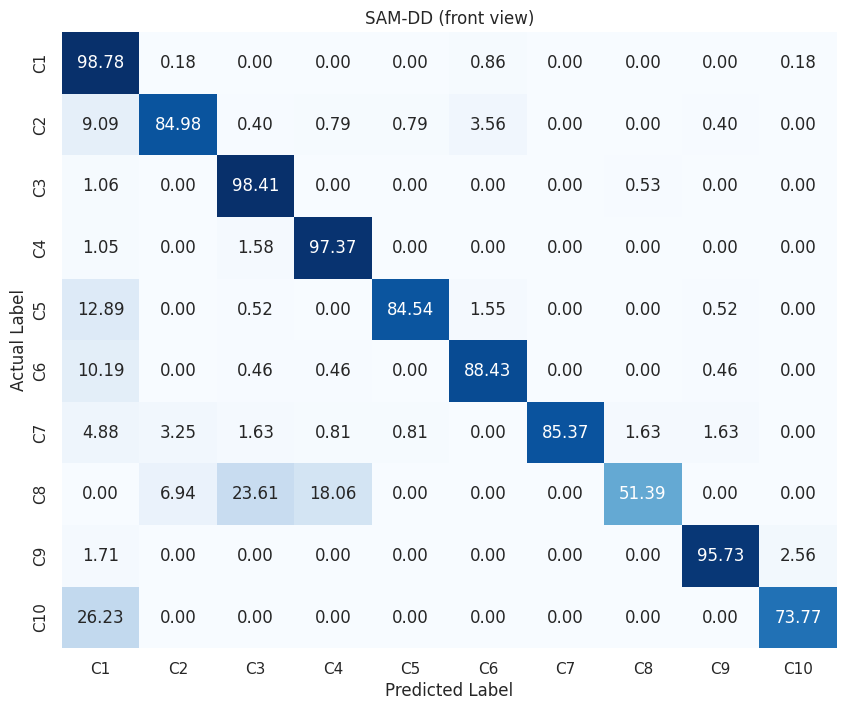

In [ ]:
num_classes = len(class_dict)
class_labels = ['C' + str(i+1) for i in range(num_classes)]

# Convert numbers into percentage
row_sums = conf_matrix.sum(axis=1, keepdims=True)
conf_matrix_percent = conf_matrix / row_sums * 100

# Format as strings up to 2 decimals
conf_matrix_percent_str = np.array([["{0:.2f}".format(value) for value in row] for row in conf_matrix_percent])

plt.figure(figsize=(10, 8))
sb.set(font_scale=1)
sb.heatmap(conf_matrix_percent, annot=conf_matrix_percent_str, fmt='', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, cbar=False)
plt.title('SAM-DD (front view)')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
conf_df = pd.DataFrame(conf_matrix, index=class_labels, columns=class_labels)
conf_path = os.path.join(log_path, 'confusion_matrix.csv')
conf_df.to_csv(conf_path)

In [ ]:
!kill -9 -1